In [1]:
import os
import re
from gensim.models import Word2Vec
from unidecode import unidecode
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\20200016\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\20200016\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
PATH = ""
os.chdir(PATH)

In [3]:
class embeddingInterpretability:
    def __init__(
            self,
            dataset_index,
            embedding_dim = 100,
            skip_gram = 1,
            n_percentage_words = 0,
            ):

        texts = self._load_texts( dataset_index )

        if not all(isinstance(i, str) for i in texts):
            raise ValueError('Not all cells in texts are strings')

        self._check_variables(
            n_percentage_words,
            embedding_dim,
            skip_gram
            )

        self.n_percentage_words = n_percentage_words

        self.preprocessed = self._preprocess_texts( texts )

        self.embedding_dim = embedding_dim
        self.skip_gram = skip_gram

        self.texts = texts
        self.model = None


    def _load_texts( self, dataset_index ):

        name_dict = {
            0:'20NewsGroup.csv',
            1:'AGNewsClassification.csv',
            2:'BbcNews.csv',
            3:'ImdbDataset.csv',
            4:'Sentiment140DatasetWith1.6MillionTweets.csv',
            5:'SpamSmsClassificationDataset.csv',
            }

        name = name_dict[ dataset_index ]
        df = pd.read_csv( name )
        texts = df['Text'].tolist()

        return texts


    def _check_variables(
            self,
            n_percentage_words,
            embedding_dim,
            skip_gram,
            ):

        if n_percentage_words <0 or n_percentage_words > 1:
            raise ValueError('Use a valid value for n: 0<= n <= 1')

        if not isinstance(embedding_dim, int):
            raise ValueError('Use a positive integer for embedding_dim')

        if not embedding_dim > 1:
            raise ValueError('Use at least an embedding_dim of 2')

        if not skip_gram in [1,0]:
            raise ValueError('Use 1 or 0 for skip_gram')


    def _preprocess_texts(
            self,
            texts = None,
            ):
        """
        The following preprocessing steps are applied:
        - lowercasing all characters,
        - removing non-alphabetic characters,
        - removing accents from characters,
        - tokenizing the text into separate words,
        - removing English stopwords,
        - optionally removing the top-n% and bottom-n% of words based on frequency.

        The percentage of words to remove is defined by the instance variable self.n_percentage_words.

        Returns
        -------
        list
            A list of lists, where each sub-list contains the preprocessed tokens from a text.
        """

        texts = texts if texts is not None else self.texts

        processed_texts = []

        nan_indices = [i for i, text in enumerate( texts ) if not isinstance( text, str )]

        filtered_texts = [text for i, text in enumerate( texts ) if i not in nan_indices]

        for text in texts:
            # lowercasing, keep text only, remove accents, tokenization
            tokens = [word for word in word_tokenize(re.sub(r'[^a-zA-Z\s]', '', unidecode(text.lower())))]
            # stopword removal
            tokens = [token for token in tokens if token not in stopwords.words('english')]
            processed_texts.append(tokens)

        # remove top-n% and bottom-n% words
        if self.n_percentage_words > 0:

            word_freq = Counter([word for sentence in processed_texts for word in sentence])

            top_n = set([word for word, _ in word_freq.most_common( int( self.n_percentage_words / 100 * len( word_freq ) ) ) ] )
            bottom_n = set([word for word, _ in word_freq.most_common()[ : -int( self.n_percentage_words / 100 * len( word_freq ) ) -1 : -1 ] ])

            processed_texts = [[word for word in sentence if word not in top_n and word not in bottom_n] for sentence in processed_texts]

        return processed_texts


    def train_word2vec(
            self,
            data = None,
            vector_size = None
            ):

        data = data if data is not None else self.preprocessed
        vector_size = vector_size if vector_size is not None else self.embedding_dim
        
        model = Word2Vec(
            data,
            vector_size=vector_size,
            min_count=1,
            sg=self.skip_gram,
        )

        model.build_vocab( corpus_iterable = data )

        model.train(
            corpus_iterable = data,
            total_examples = len( data ),
            epochs = 20,
        )
        
        self.model = model

        return model


    def get_word_vectors(
            self,
            doc,
            model = None,
            ):

        word_vector = [ model.wv[word] for word in doc if len(doc) > 0 ]

        return word_vector


    def expand_vector( self, vector, target_dim ):

        degree = 2

        while True:
            poly = PolynomialFeatures ( degree )
            expanded = poly.fit_transform ( vector.reshape( 1, -1 ) )

            if expanded.shape[1] >= target_dim:
                break

            degree+=1

        expanded = expanded.flatten()

        if len( expanded ) > target_dim:
            expanded = expanded[ : target_dim]

        return expanded


    def convert_top_k_values( self, arr, k ):

        if not ( 1 <= k <= arr.shape[1] ):
            raise ValueError("K must be between 1 and the number of columns")

        top_k_indices = np.argsort( arr, axis=1 )[ :, -k: ]

        result = np.zeros( arr.shape )

        row_indices = np.arange( arr.shape[0] )[ : , None]

        result[ row_indices, top_k_indices ] = 1

        return result


    def map_to_higher_dimension_np(self, X, k):

        def calculate_combinations(n_features, degree):
            """
            Calculate the number of polynomial combinations based on the number of features and the polynomial degree.
            """
            return np.math.factorial(n_features + degree) / (np.math.factorial(n_features) * np.math.factorial(degree))

        def find_polynomial_degree(n_features, k):
            """
            Find the smallest polynomial degree such that the number of dimensions after transformation is at least k.
            """
            degree = 0
            while calculate_combinations(n_features, degree) < k:
                degree += 1
            return degree

        def generate_feature_combinations(features, degree):
            """
            Generate all feature combinations for a given degree.
            """
            combination_indices = combinations_with_replacement(range(features.shape[1]), degree)
            return np.array([np.prod(features[:, indices], axis=1) for indices in combination_indices]).T


        n_samples, n_features = X.shape
        degree = find_polynomial_degree(n_features, k)

        # Start with bias term if include_bias, else start with original features
        transformed_features = [np.ones((n_samples, 1))]  # You can remove this if you don't want the bias term

        # Generate feature combinations for each degree
        for d in range(1, degree + 1):
            transformed_features.append(generate_feature_combinations(X, d))

        # Concatenate all feature combinations
        X_transformed = np.hstack(transformed_features)

        # Trim features if necessary to match k as closely as possible
        if X_transformed.shape[1] > k:
            X_transformed = X_transformed[:, :k]

        return X_transformed
    
    
    def get_words_for_dimensions( self, vectors, model = None ):
        
        if not model:
            if self.model:
                model = self.model
            else:
                raise ValueError("A model needs to be trained before we can get the words")
        
        transposed_embedding = vectors.T
        words_per_dimension = []

        for dim in transposed_embedding:
            
            indices_with_1 = [dataset_index for dataset_index, value in enumerate(dim) if value == 1]            
            words = [ model.wv.index_to_key[dataset_index] for dataset_index in indices_with_1 ]  
            words_per_dimension.append(words)
        
        return words_per_dimension

            
    def create_histogram_for_dimensions( self, list_of_lists ):
        sublist_lengths = [len(sublist) for sublist in list_of_lists]

        # Create the histogram
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(sublist_lengths)), sublist_lengths, color='blue')

        # Adding labels and title
        plt.xlabel('Dimension')
        plt.ylabel('Number of Words in Dimension')
        plt.title('Histogram of Words per Dimension')
        plt.xticks(range(len(sublist_lengths)), range(1, len(sublist_lengths)+1))  # X-axis labels as Dimension numbers

        # Show the plot
        plt.show()

    
    def get_texts(self):
        return self.texts


    def get_proprocessed_texts(self):
        return self.preprocessed


# Let's experiment with the BBC Dataset. Models trained on this dataset performed best in my other experiments.

In [4]:
bbc = embeddingInterpretability( 2 )

In [5]:
texts = bbc.get_texts()

In [6]:
print(texts[0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

In [7]:
total_length = 0
vocabulary = set()
for text in texts:
    words = text.split()  # Split the text into individual words
    total_length += len(words)
    vocabulary.update(words)

print(f"Number of documents: {len(texts)}")
print(f"Average number of words per document: {round(total_length/len(text))}")
print(f"Vocabulary size: {len(vocabulary)}")



Number of documents: 1490
Average number of words per document: 333
Vocabulary size: 35594


# Approach 1: convert embeddings into binary representation without mapping to a higher dimensional space. 

In [8]:
model = bbc.train_word2vec(vector_size = 128)
vectors = model.wv.vectors

In [9]:
print(f"Number of stopwords removed: {len(stopwords.words())}")
print(f"Embedding dimensions: {vectors.shape}")

Number of stopwords removed: 10405
Embedding dimensions: (25235, 128)


In [10]:
binary = bbc.convert_top_k_values( vectors, 2 )
print(f"Embedding converted to binary: {binary[0]}")

Embedding converted to binary: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
words_per_dimension = bbc.get_words_for_dimensions( binary, model )

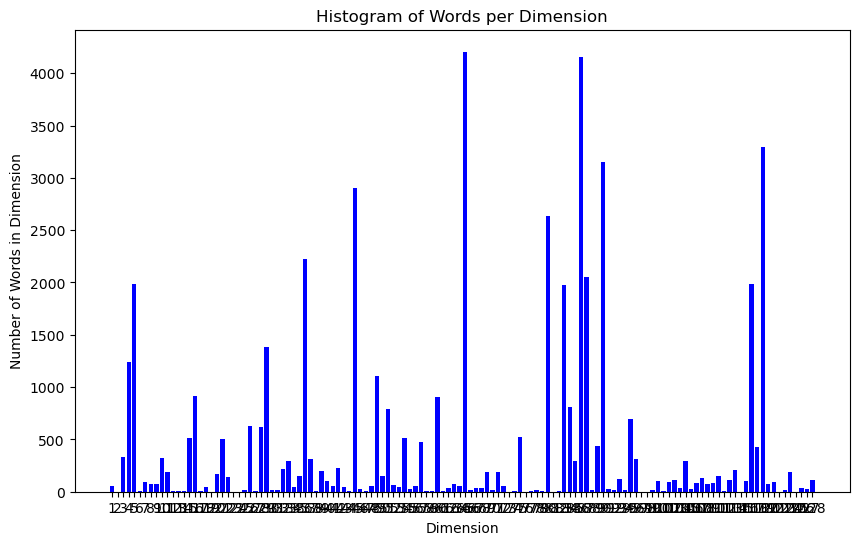

In [12]:
bbc.create_histogram_for_dimensions( words_per_dimension )

These embeddings are not very interpretable

In [13]:
for i, dim in enumerate(words_per_dimension):
    print(f"{i}: {dim}\n")

0: ['british', 'london', 'enough', 'society', 'kind', 'finding', 'quickly', 'inside', 'weak', 'supply', 'servers', 'balance', 'engineering', 'sit', 'steal', 'slowing', 'unfortunately', 'cultural', 'generate', 'fairly', 'center', 'border', 'silicon', 'technically', 'reluctant', 'rajasthan', 'cruise', 'motivate', 'lighting', 'pitches', 'ears', 'mile', 'layout', 'distributors', 'compliance', 'interaction', 'inclined', 'marketplace', 'convergence', 'savvy', 'deter', 'idndisabled', 'scepticism', 'chemistry', 'visas', 'indicative', 'rigid', 'mains', 'bewildered', 'tighten', 'holyrood', 'mailings', 'overlyzealous', 'disruptions', 'bide', 'paule', 'susceptible']

1: ['chairman', 'michigan']

2: ['time', 'firm', 'games', 'top', 'business', 'firms', 'came', 'january', 'star', 'yearold', 'women', 'global', 'possible', 'asked', 'reported', 'wants', 'included', 'named', 'admitted', 'via', 'moment', 'machines', 'magazine', 'device', 'keen', 'hoping', 'electronics', 'road', 'holmes', 'movies', 'singl

# Approach 2: map embeddings to a higher dimension

In [14]:
vectors_higher_dimension = bbc.map_to_higher_dimension_np( vectors, 256 )


In [15]:
print(f"Shape vectors in higher dimension: {vectors_higher_dimension.shape}")
print(f"First embedding: {vectors_higher_dimension[0][0:50]}")

Shape vectors in higher dimension: (25235, 256)
First embedding: [ 1.          0.13918881  0.04038085  0.15539013  0.04159433  0.17143382
 -0.38725445 -0.22037804  0.09895324 -0.2227691   0.3543756   0.41629583
 -0.16063435 -0.20803069 -0.15988629  0.372448   -0.0882653  -0.10618832
 -0.13177888 -0.4711954  -0.11132891  0.28898349  0.1382408  -0.4211866
 -0.38658294  0.08814761  0.15052265 -0.2489564   0.48264158  0.18766527
  0.03640439 -0.37163559  0.11816756  0.05956548 -0.04261471 -0.32819387
  0.04369609  0.28858179  0.30709341  0.29520783  0.38229594 -0.35857859
 -0.23816282 -0.04191114  0.02178643  0.20451193 -0.32348353 -0.22771049
 -0.02827741  0.32823095]


In [16]:
binary_high_dimensions = bbc.convert_top_k_values( vectors_higher_dimension, 2 )

In [17]:
print( binary_high_dimensions[0] )

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
words_per_dimension = bbc.get_words_for_dimensions( binary_high_dimensions, model )

Note: The words in the histogram are not well distributed. Barely any of the newly added dimensions have the highest weights. This might indicate that the mapping approach used is not the right one. 

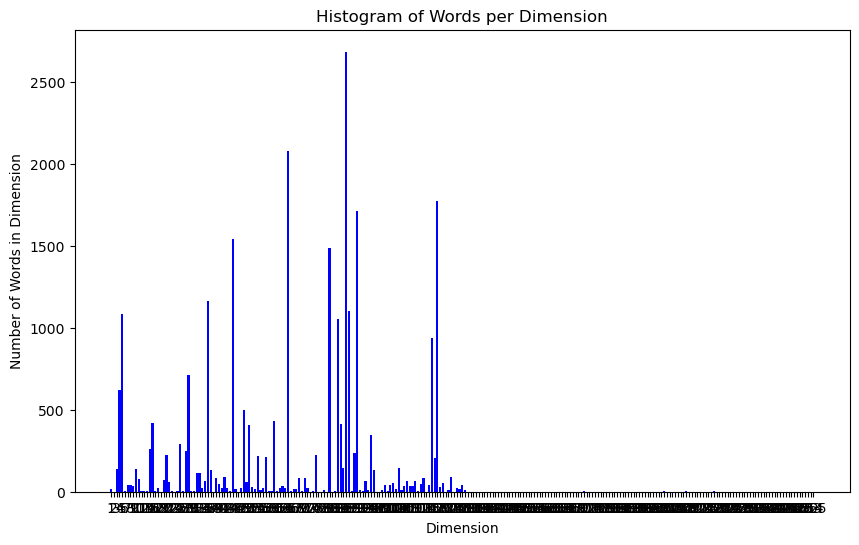

In [19]:
bbc.create_histogram_for_dimensions(words_per_dimension[1:])

Also the words per topic are not very interpretable:

In [20]:
for i, dim in enumerate(words_per_dimension[1:]):
    print(f"{i}: {dim}\n")

0: ['enough', 'society', 'quickly', 'inside', 'supply', 'balance', 'engineering', 'steal', 'slowing', 'center', 'reluctant', 'rajasthan', 'layout', 'distributors', 'savvy', 'idndisabled', 'mailings', 'bide']

1: ['chairman']

2: ['time', 'firm', 'top', 'business', 'firms', 'january', 'star', 'yearold', 'women', 'global', 'reported', 'wants', 'included', 'admitted', 'magazine', 'keen', 'electronics', 'road', 'holmes', 'movies', 'singles', 'millions', 'insurance', 'maker', 'grow', 'owners', 'entry', 'scott', 'controls', 'comeback', 'jason', 'audio', 'medical', 'christian', 'resources', 'topped', 'dedicated', 'required', 'vegas', 'hitech', 'gareth', 'compiled', 'passport', 'saudi', 'clijsters', 'carpenter', 'prefer', 'cultural', 'laboratory', 'pirates', 'slowly', 'norfolk', 'wta', 'publisher', 'stated', 'inclusion', 'bronze', 'psychological', 'colours', 'helsinki', 'admit', 'rampant', 'oldest', 'fastestgrowing', 'sustaining', 'sonia', 'muchanticipated', 'pink', 'absent', 'worthy', 'touted

# Approach 3: train an embedding already with 256 dimensions

In [21]:
model = bbc.train_word2vec( vector_size = 256 )
vectors = model.wv.vectors

In [22]:
binary = bbc.convert_top_k_values( vectors, 2 )
print(f"Embedding converted to binary: {binary[0]}")

Embedding converted to binary: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
words_per_dimension = bbc.get_words_for_dimensions( binary, model )

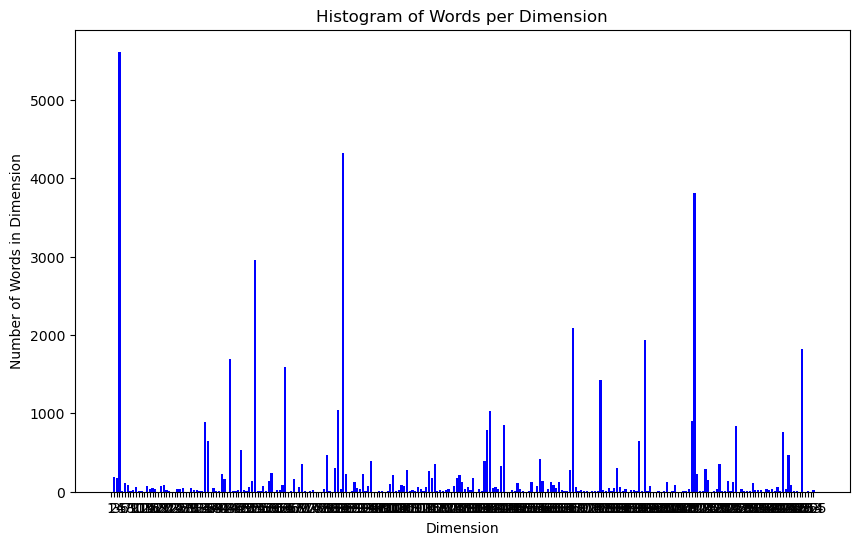

In [24]:
bbc.create_histogram_for_dimensions(words_per_dimension[1:])

In [25]:
for i, dim in enumerate(words_per_dimension[1:]):
    print(f"{i}: {dim}\n")

0: ['monthly', 'monitor']

1: ['mr', 'hard', 'email', 'web', 'helped', 'love', 'sound', 'malicious', 'multimedia', 'chris', 'effectively', 'material', 'creating', 'outlook', 'anniversary', 'breaking', 'promote', 'solutions', 'attempting', 'doubled', 'chat', 'surfers', 'chain', 'witness', 'affordable', 'conspiracy', 'truly', 'scholes', 'rubber', 'proportion', 'commodity', 'unfortunate', 'protecting', 'everyday', 'flash', 'phenomenal', 'surround', 'evolution', 'smash', 'extensive', 'relation', 'worms', 'etc', 'tenfold', 'wings', 'hiding', 'blocks', 'kinds', 'illegitimate', 'burke', 'holy', 'unprecedented', 'campaigner', 'attachments', 'travels', 'rsa', 'notebook', 'toxic', 'sounded', 'bears', 'fifty', 'valley', 'creativity', 'infested', 'displaying', 'updates', 'accelerated', 'inaccurate', 'detect', 'subscriber', 'invariably', 'blast', 'disclosed', 'reopening', 'portals', 'havenots', 'unlawful', 'rendered', 'capitalised', 'numerical', 'outgoing', 'militant', 'symmons', 'uncomfortable', '